# Overall description

In [1]:
# This is an 3D example code based on SimPEG package.
# All cases are designed for on-land survey using 
# feequency domain CSEM method, with a line source.

# Author: Zhuo Liu, Colorado School of Mines
# Created in May, 2020

# Import packages

In [245]:
# Import packages

import math as m
import numpy as np
import SimPEG as spg
from discretize import TreeMesh, TensorMesh
from SimPEG.utils  import ExtractCoreMesh
import SimPEG.electromagnetics.frequency_domain as FDEM
import pyvista as pv
from pymatsolver import Pardiso
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Define functions

In [329]:
# Self defined fucntions, for a succinct code and versatility

# Define function to construct anomalous bodies
def SinglebodyTensorMesh3D(core_x, core_y, core_z, core_hx, core_hy, core_hz, 
                           npadx, npady, npadz, pad_factor
                          ):
    '''
    Input: core_x/ core_y/ core_y: The length of core region in 3 directions in meter, int;
           core_hx/ core_hy/ core_hz: Cell widths in the core region of the mesh in meter, int;
           npadx/ npady/ npadz: Number of padding cells in each dimension;
           pad_factor: Padding factor
    
    Output: mesh: tensor mesh, with single densily-meshed region
    '''
    
    # Calculate the number of cells in core region
    n_core_x, n_core_y, n_core_z = int(core_x/core_hx), int(core_y/core_hy), int(core_z/core_hz)
    
    # Make meshed space
    mesh = TensorMesh([
        [(core_hx, npadx, -pad_factor), (core_hx, n_core_x), (core_hx, npadx, pad_factor)],
        [(core_hy, npady, -pad_factor), (core_hy, n_core_y), (core_hy, npady, pad_factor)],
        [(core_hz, npadz, -pad_factor), (core_hz, n_core_z), (core_hz, npadz, pad_factor)]
    ])
     
    return mesh


# Define function to construct anomalous bodies
def MultibodyTreeMesh3D(basemesh, x_bound, y_bound, z_bound, methods, tree_level):
    '''
    Input: basemesh: The basemesh need to be refined, SimPEG.Mesh;
           x_bound: Boundary of each region in x-direction, 1D array or list.
                    organized as [x1start, x1end, x2start, x2end...]
           y_bound: Boundary of each region in y-direction, 1D array or list.
                    organized as [y1start, y1end, y2start, y2end...]
           z_bound: Boundary of each region in z-direction, 1D array or list.
                    organized as [y1start, y1end, y2start, y2end...]
           methods: Method to refine mesh.
           tree_level: 
    
    Output: mesh: Tree mesh with multiple anomalous region, mesh
    '''
    
    if len(x_bound) == len(y_bound) == len(z_bound):

        nbody = int(len(x_bound)/2)

        for n in range(nbody):
            # Construct vectors of all vertices for nth anomalous body
            xyz = spg.Utils.ndgrid([np.r_[x_bound[2*n],x_bound[2*n+1]], 
                                    np.r_[y_bound[2*n],y_bound[2*n+1]], 
                                    np.r_[z_bound[2*n],z_bound[2*n+1]]])    # Extrate vertices for nth anomalous body

            # Discretize to finest cell size within rectangular box
            mesh = refine_tree_xyz(basemesh, xyz, 
                                   octree_levels=[tree_level[3*n], tree_level[3*n+1], tree_level[3*n+2]], 
                                   method=methods[n], 
                                   finalize=False
                                  )

        mesh.finalize()
    
    else:
        raise Exception('length of x_bound, y_bound, and z_bound should be same')
    
    return mesh


# Define function to fill the mesh with physical property values
def ModelConstruct3D(mesh, physivalue, x_bound, y_bound, z_bound):
    '''
    Input: mesh: The mesh created for modeling, SimPEG.Mesh;
           physivalue: Physical property values, 1D array;
           x_bound: Boundary of each region in x-direction, 1D array or list.
                    organized as [x1start, x1end, x2start, x2end...]
           y_bound: Boundary of each region in y-direction, 1D array or list.
                    organized as [y1start, y1end, y2start, y2end...]
           z_bound: Boundary of each region in z-direction, 1D array or list.
                    organized as [y1start, y1end, y2start, y2end...]
    
    Tip: 1. All inputs should be organized in an order from large-region to small-region;
         2. All bound values should be organized in an order from lower value to highre value.
    
    Output: model: the model, array
    '''
    
    nvalue = len(physivalue)
    
    model = np.ones(mesh.nC)    # Initialize model vector
    
    for i in range(nvalue):
        index = (
            (mesh.gridCC[:, 0]>=x_bound[2*i]) & (mesh.gridCC[:, 0]<=x_bound[2*i+1]) &
            (mesh.gridCC[:, 1]>=y_bound[2*i]) & (mesh.gridCC[:, 1]<=y_bound[2*i+1]) &
            (mesh.gridCC[:, 2]>=z_bound[2*i]) & (mesh.gridCC[:, 2]<=z_bound[2*i+1])
        )

        model[index] = physivalue[i]    #Set rock-background

    return model


# Define function to fill the mesh with physical property values
def ModelConstruct2D(mesh, physivalue, x_bound, z_bound):
    '''
    Input: mesh: The mesh created for modeling, SimPEG.Mesh;
           physivalue: Physical property values, 1D array;
           x_bound: Boundary of each region in x-direction, 1D array or list.
                    organized as [x1start, x1end, x2start, x2end...]
           z_bound: Boundary of each region in z-direction, 1D array or list.
                    organized as [y1start, y1end, y2start, y2end...]
    
    Tip: 1. All inputs should be organized in an order from large-region to small-region;
         2. All bound values should be organized in an order from lower value to highre value.
    
    Output: model: the model, array
    '''
    
    nvalue = len(physivalue)
    
    model = np.ones(mesh.nC)    # Initialize model vector
    
    for i in range(nvalue):
        index = (
            (mesh.gridCC[:, 0]>=x_bound[2*i]) & (mesh.gridCC[:, 0]<=x_bound[2*i+1]) &
            (mesh.gridCC[:, 1]>=z_bound[2*i]) & (mesh.gridCC[:, 1]<=z_bound[2*i+1])
        )

        model[index] = physivalue[i]    #Set model value to the current region

    return model


# Define function to calculate skin septh
def Skin_Depth(sigma_list, freq_list):
    sigma = np.unique(sigma_list)
    freq = np.unique(freq_list)
    skin_depth = []
    for f in freq:
        for s in sigma:
            skin_depth.append(500./np.sqrt(s * f))
    
    return skin_depth


# Define functino to find out the nearest point of a location on a grid
def NearestLoc1D(loc, grid):
    '''
    Input: loc: target location, float;
           grid: a series of locations to be compaired againest, 1D array;
    
    Output: nearest_poin:, the point on the grid that closest to the loc, float
    '''
    
    distance = np.abs(grid - loc)
    nearest_point = grid[np.where(distance == distance.min())]
    
    return nearest_point


# Defing function to generate topography vector
def topo2D(mesh, topo_xyz):
    '''
    Input: mesh: The mesh created for modeling, SimPEG.Mesh;
           topo_xyz: Coordinate of control points of topography, n*3 array;
    
    Output: topo_vec: a vector, with length of mesh.gridCC[:,0], of elevation/depth, array
    '''
    
    mesh_x = mesh.gridCC[:,0]
    face_x = np.unique(mesh.gridEy[:,0])
    face_y = np.unique(mesh.gridEx[:,1])
    
    topo_vec = np.zeros_like(mesh_x)
    mesh_x_vec = np.unique(mesh.gridCC[:,0])

    # Set boundary elevation outside of control point range    
    # Actually, I won't recomment the have the mesh larger than the grid of control point 
    if mesh_x.min() < topo_xyz[:, 0].min() or mesh_x.max() > topo_xyz[:, 0].max():
        print('\n Better to have the mesh no larger than the area defined by the grid of control points. \n')
        topo_vec[mesh_x < topo_xyz[:, 0].min()] = topo_xyz[0, 2]
        topo_vec[mesh_x > topo_xyz[:, 0].max()] = topo_xyz[-1, 2]
    if mesh_x.min() > topo_xyz[:, 0].min() or mesh_x.max() < topo_xyz[:, 0].max():
        raise Exception('Mesh too samll, control points outside of mesh region.')
    
    for t in range(topo_xyz.shape[0]-1):
        # Calculate slope for the current section 
        dx = topo_xyz[t+1, 0] - topo_xyz[t, 0]
        dz = topo_xyz[t+1, 2] - topo_xyz[t, 2]
        slope = dz/dx
        
        # Find the closest point on mesh_x to the current section ends
        section_start = NearestLoc1D(topo_xyz[t, 0], mesh_x_vec)
        section_end = NearestLoc1D(topo_xyz[t+1, 0], mesh_x_vec)
        topo_vec[mesh_x == section_start] = topo_xyz[t, 2]
        topo_vec[mesh_x == section_end] = topo_xyz[t+1, 2]
        section = mesh_x_vec[(mesh_x_vec >= section_start) & (mesh_x_vec <=section_end)]
        
        for p in range(len(section)-1):
            dx_sec = section[p+1] - section[0]
            dz_sec = slope * dx_sec
            elevation_top = topo_xyz[t, 2] + dz_sec
            topo_vec[mesh_x == section[p+1]] = elevation_top
    
    return topo_vec


# Define function to find the smallest square root number for plotting
def Plot_Grid(num):
    i = 0
    root_found = False
    while root_found is False:
        squre = i ** 2
        if squre >= num:
            root_found = True
            root = i
        else:
            i += 1
            pass
    
    return root



# Control Panel

In [318]:
# Set control sequences for outputs

# Switch for plotting
Plot_Mesh_3D = True
Plot_Mesh_2D = True
Plot_Model = True
Plot_Survey = True
Plot_Complex = True
Plot_Data = True

# Switch for saving plots
Save_Plot_Mesh_2D = True
Save_Plot_Mesh_3D = True
Save_Topo = True
Save_Plot_Model = True
Save_Plot_Survey = True
Save_Complex = True
Save_Plot_Data = True

# Switch for saving data
Save_Data = True
Save_Field_Parameter = True

# Folder path to save figures/
Save_path = '/Users/zhuoliu/Desktop/Docs/Mines/7 Fall 2019/国内合作项目/西北有色/模型模拟/2020 第二批实地模型/正演结果/模型4_二里河/模型4_二里河_有地形_实际电阻率/'


# Set Forward Model and Survey

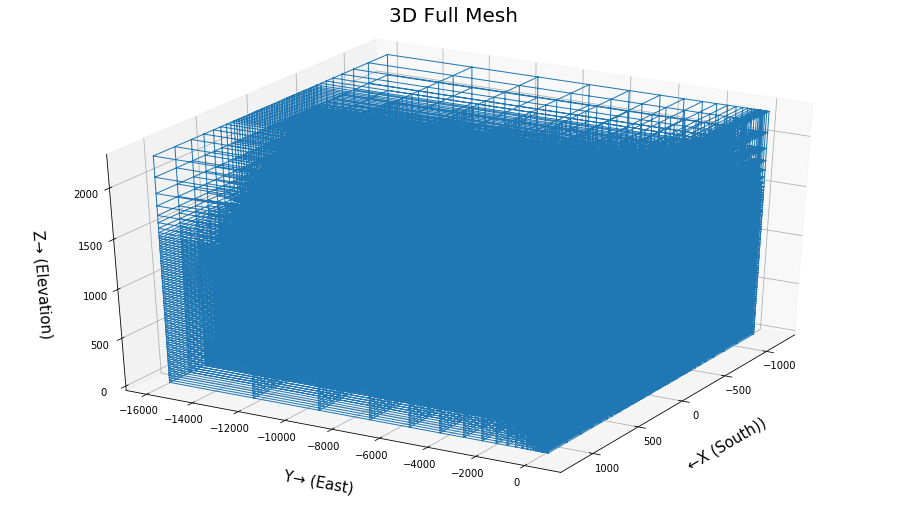

There are 78336 cells in the 3D mesh


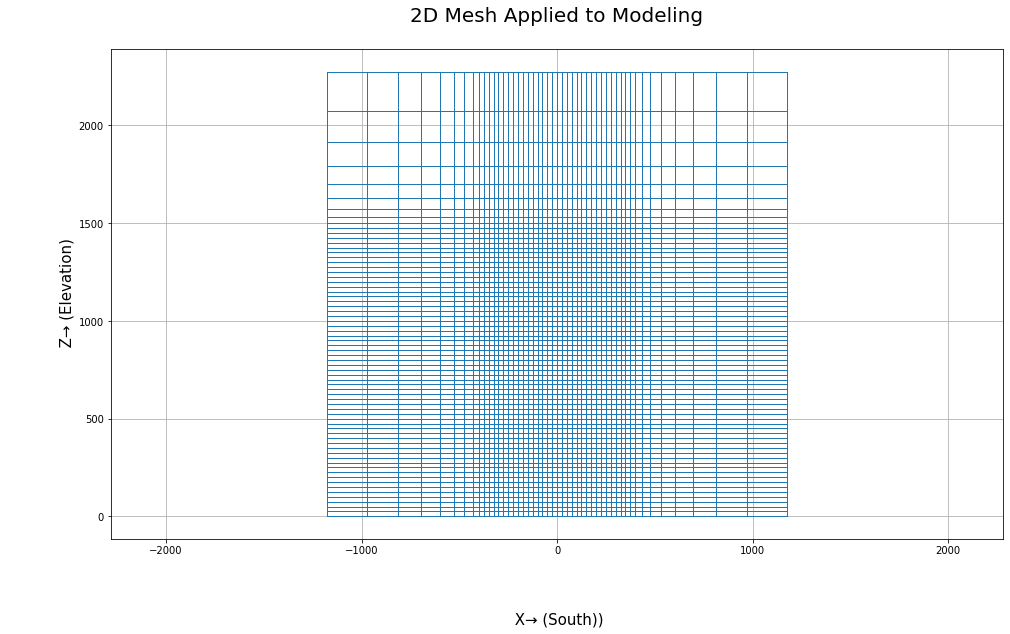

There are 3264 cells in the 2D mesh

 Better to have the mesh no larger than the area defined by the grid of control points. 



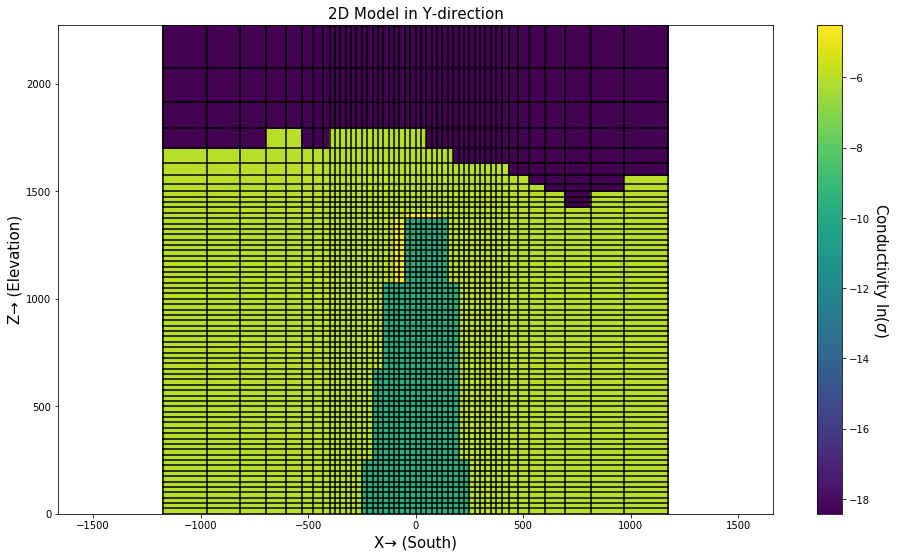

Skin depths is between 52.41m and 6324555.32m


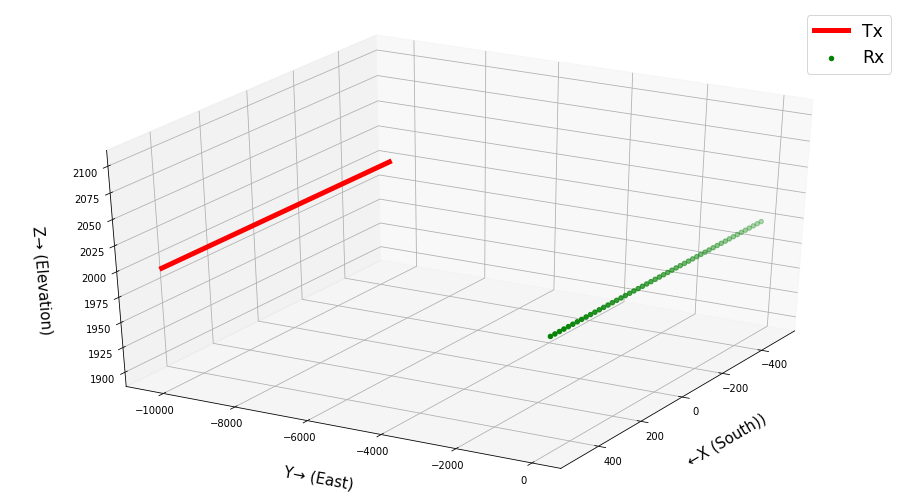

In [326]:
# Set model space and value

# Set the length of core region in 3 directions
core_x, core_y, core_z = 800, 1, 1500 # Unit in meter    

# cell widths in the core region of the mesh
core_hx, core_hy, core_hz = 25, 25, 25    # Unit in meter

# Number of padding cells in each dimension
npadx, npady, npadz = 8, 19, 8

# Padding factor
pad_factor = 1.3

# Construct 3D full mesh 
Full_mesh = SinglebodyTensorMesh3D(core_x, core_y, core_z, core_hx, core_hy, core_hz,
                              npadx, npady, npadz, pad_factor)

# Calculate the number of cells in core region
n_core_x, n_core_y, n_core_z = int(core_x/core_hx), int(core_y/core_hy), int(core_z/core_hz)

# Shift the center of the tensor mesh
Full_mesh.x0 = np.r_[
    0, 
    -(Full_mesh.hy[:n_core_y+npady+5].sum()),
    -(Full_mesh.hz[: npadz].sum())
    ]

# Corp meshes
Full_mesh = TensorMesh([Full_mesh.hx, 
                        Full_mesh.hy[Full_mesh.vectorCCy <= 0], 
                        Full_mesh.hz[Full_mesh.vectorCCz >= 0]]
                      )
mesh_2D = TensorMesh([Full_mesh.hx, Full_mesh.hz])

# Shift the center of the tensor mesh, again
Full_mesh.x0 = np.r_[
    -(Full_mesh.hx.sum()*0.5),    # Set zeor in x-direction to the middle
    -(Full_mesh.hy[:n_core_y+npady].sum()),    # Set zero in y-direction to the top
    0
    ]
mesh_2D.x0 = Full_mesh.x0[[0, 2]]

# Plot the full 3D mesh and print the number of cells
if Plot_Mesh_3D is True:
    Mesh_3D_fig = plt.figure(1, figsize = (16,9))
    Mesh_3D_plot = plt.subplot(111, projection='3d')
    Full_mesh.plotGrid(ax=Mesh_3D_plot)
    plt.title('3D Full Mesh\n', fontsize=20, loc='center')
    Mesh_3D_plot.set_xlabel('\n\n\n ←X (South))', fontsize=15)
    Mesh_3D_plot.set_ylabel('\n\n\n Y→ (East)', fontsize=15)
    Mesh_3D_plot.set_zlabel('\n\n\n Z→ (Elevation)', fontsize=15, rotation=180)
    Mesh_3D_plot.view_init(32, 30)    # Set view angle, make it clear that we use right-handed coordinate system.
    plt.show()
    print(f"There are {Full_mesh.nC} cells in the 3D mesh")

    if Save_Plot_Mesh_3D is True:
        Mesh_3D_fig_name = 'CSEM Full 3D Mesh'
        Mesh_3D_fig.savefig(Save_path + Mesh_3D_fig_name + '.png',
                         transparent=True)
    
# Plot the actual 2D mesh and print the number of cells
if Plot_Mesh_2D is True:
    Mesh_2D_fig = plt.figure(2, figsize = (16,9))
    Mesh_2D_plot = plt.subplot(111)
    mesh_2D.plotGrid(ax=Mesh_2D_plot)
    plt.title('2D Mesh Applied to Modeling\n', fontsize=20, loc='center')
    Mesh_2D_plot.set_xlabel('\n\n\n X→ (South))', fontsize=15)
    Mesh_2D_plot.set_ylabel('\n\n\n Z→ (Elevation)', fontsize=15) 
    plt.axis('equal')
    plt.show()
    print(f"There are {mesh_2D.nC} cells in the 2D mesh")

    if Save_Plot_Mesh_2D is True:
        Mesh_2D_fig_name = 'CSEM Acutal 2D Mesh'
        Mesh_2D_fig.savefig(Save_path + Mesh_2D_fig_name + '.png',
                         transparent=True)

# Map 2D mesh to 3D space
mapping = spg.maps.Surject2Dto3D(Full_mesh)

factor = 1.4

# Incorporate model value into the mesh
sigma_list = np.r_[1e-8, 1/400, 1/15232, 1/15232, 1/15232, 1/15232, 1/90, 1/90]    # Conductivity for air whole space, host-rock half space, and anomalous block

# Set the region for different model values
x_bound_source=[mesh_2D.gridFx.min(), mesh_2D.gridFx.max(),    # Air layer
                mesh_2D.gridFx.min(), mesh_2D.gridFx.max(),    # Host rock
                -250, 250,    # Conductive block 
                -200, 200,
                -150, 200,
                -100, 150, 
                -50, 100,
                -100, -50,
               ]
z_bound_source=[2000, mesh_2D.gridFy.max(),
                mesh_2D.gridFy.min(), 2000,
                0, 175*factor,
                175*factor, (175+300)*factor,
                (175+300)*factor, (175+300+300)*factor,
                (175+300+300)*factor, (175+300+300+200)*factor,
                (175+300+300+200)*factor, (175+300+300+200+25)*factor,
                (175+300+300)*factor, (175+300+300+200)*factor,      
               ]

# Fill the meshed space with model values
sigma = ModelConstruct2D(mesh_2D, sigma_list, x_bound_source, z_bound_source)    # Fill model values to the mesh

# Define topography
topo_x = np.r_[-1000, -825, -593, -472, -278, -165, 0, 
              270, 405, 615, 810, 1000]    # Set control points
topo_y = np.r_[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ]
topo_z = np.r_[1695, 1718, 1755, 1725, 1808, 1770, 1770, 
               1605, 1605, 1500, 1418, 1515]
topo_control_points = np.c_[topo_x, topo_y, topo_z]
topo_vec = topo2D(mesh_2D, topo_control_points)

if Save_Topo is True:
     # Save the topography data
    Topo_file_name = 'Topo data' 
    Full_Save_Path = Save_path + Topo_file_name
    np.save(Full_Save_Path, topo_control_points)    # Save e_data as .npy file, in the same folder with figures

# Incorporate topography
sigma[mesh_2D.gridCC[:, 1] > topo_vec] = sigma_list[0]

# Plot the 2D model
if Plot_Model is True:
    Model_fig = plt.figure(3, figsize=(16,9))
    Model_plot = plt.subplot(111)
    Filled_model = mesh_2D.plotImage(np.log(sigma), 
                              ax=Model_plot,
                              grid=True)
    plt.title('2D Model in Y-direction', fontsize=15)
    plt.xlabel('X→ (South)', fontsize=15)
    plt.ylabel('Z→ (Elevation)', fontsize=15)
    plt.axis('equal')
    bar2 = plt.colorbar(Filled_model[0])
    bar2.set_label(label='Conductivity $\ln(\\sigma)$', fontsize=15, rotation=270, labelpad=20)
    plt.show()

    if Save_Plot_Model is True:
        Model_fig_name = 'CSEM 2D Model'
        Model_fig.savefig(Save_path + Model_fig_name + '.png',
                          transparent=True)

# Source locations
# For line source, use solenoid to approximate. Place solenoid on the cell edge.
Tx_x_lim = np.r_[-500, 500]
Tx_loc_x = Full_mesh.vectorNx[(Full_mesh.vectorNx>=Tx_x_lim[0]) & (Full_mesh.vectorNx<=Tx_x_lim[1])]    # Station location in x-direction
Tx_loc_y = np.r_[-10300]    # Station location in y-direction
Tx_loc_z = np.r_[2000]    # Station location in z-direction
freq_list = np.r_[8192, 7168, 6144, 5120, 4096, 3584, 3072,
                  2560, 2048, 1792, 1536, 1280, 1024, 896,
                  768, 640, 512, 448, 384, 320, 256,
                  224, 192, 160, 128, 112, 96, 80,
                  64, 56, 48, 40, 32, 28, 24,
                  20, 16, 14, 12, 10, 8, 7,
                  6, 5, 4, 3.5, 3, 2.5, 2,
                  1.75, 1.5, 1.25, 1, 0.875, 0.75, 0.625
                 ]    # Source frequency in Hz
source_moment = 30

# Receiver locations
Rx_loc_x = np.linspace(-500,500, 51)    # obs points
Rx_loc_y = np.r_[0]    # obs lines
Rx_loc_z = np.r_[2000]    # obs elevation

# Construct source vector
Tx_locs = spg.utils.ndgrid([Tx_loc_x, Tx_loc_y, Tx_loc_z])    # Sourrce coordinates
Tx_index = spg.utils.closestPoints(Full_mesh, Tx_locs)[1:]    # [1:] is needed to drop the first point outside of the ssrc_x_lim
Tx_vec_x = np.zeros(Full_mesh.nEx)
Tx_vec_y = np.zeros(Full_mesh.nEy)
Tx_vec_z = np.zeros(Full_mesh.nEz)
Tx_vec_x[Tx_index] = source_moment    # Source vector, number is intensity
Tx_vec = np.hstack((Tx_vec_x, Tx_vec_y, Tx_vec_z))
    
# Generate receiver coordinates as array
Rx_locs = spg.utils.ndgrid(Rx_loc_x, Rx_loc_y, Rx_loc_z)    

# Set up the survey problem fir Electric field/data (E, with EB formulation)
Rx_e_real = FDEM.receivers.PointElectricField(Rx_locs, orientation="x",component='real')
Rx_e_imag = FDEM.receivers.PointElectricField(Rx_locs, orientation="x",component='imag')
Rx_e = [Rx_e_real, Rx_e_imag]

# Calculate skin depth
skin_depth = Skin_Depth(sigma_list, freq_list)

# Plot EM survey, namely, the location of Tx and Rx
if Plot_Survey is True:
    srx_x = Tx_x_lim
    src_y = np.r_[Tx_loc_y, Tx_loc_y]
    src_z = np.r_[Tx_loc_z, Tx_loc_z]
    Survey_fig = plt.figure(4, figsize=(16,9))
    Survey_plot = plt.subplot(111, projection='3d')
    Survey_plot.plot(srx_x, src_y, src_z, c='red', linewidth=5, label='Tx')
    Survey_plot.scatter(Rx_locs[:,0], Rx_locs[:,1], Rx_locs[:,2], c='green', label='Rx')
    Survey_plot.set_xlabel('\n\n\n ←X (South))', fontsize=15)
    Survey_plot.set_ylabel('\n\n\n Y→ (East)', fontsize=15)
    Survey_plot.set_zlabel('\n\n\n Z→ (Elevation)', fontsize=15, rotation=180)
    Survey_plot.view_init(32, 30)    # Set view angle, make it clear that we use right-handed coordinate system.
    Survey_plot.legend(fontsize='xx-large')
    print('Skin depths is between ' + 
          str(round(min(skin_depth),2))+ 'm and ' 
          + str(round(max(skin_depth),2)) + 'm')
    plt.show()

    if Save_Plot_Survey is True:
        Survey_fig_name = 'CSEM Survey'
        Survey_fig.savefig(Save_path + Survey_fig_name + '.png',
                          transparent=True)


# Calculate field and data

In [327]:
# Set up survey and problem pair

# Setup source, approximate line souce by RawVec
freq_count = 0
srcList_e = []
e_data = np.zeros((len(freq_list), 2*len(Rx_locs)))    # Create array to store data
for freq in freq_list:
    src_term_e = FDEM.sources.RawVec_e(Rx_e, freq, Tx_vec)    # Approximation of line source. Will change
    srcList_e.append(src_term_e)

# Define EM problem for E measurement
survey_e = FDEM.Survey(srcList_e)
simulation_e = FDEM.simulation.Simulation3DElectricField(Full_mesh, sigmaMap = mapping,
                                                         survey=survey_e,
                                                         Solver=Pardiso, verbose=True)

# Pair the physics and survey
simulation_e.pair(survey_e)

# Calculate electric data data
e_data = simulation_e.dpred(sigma)    # Calculate electric data


# Plot results

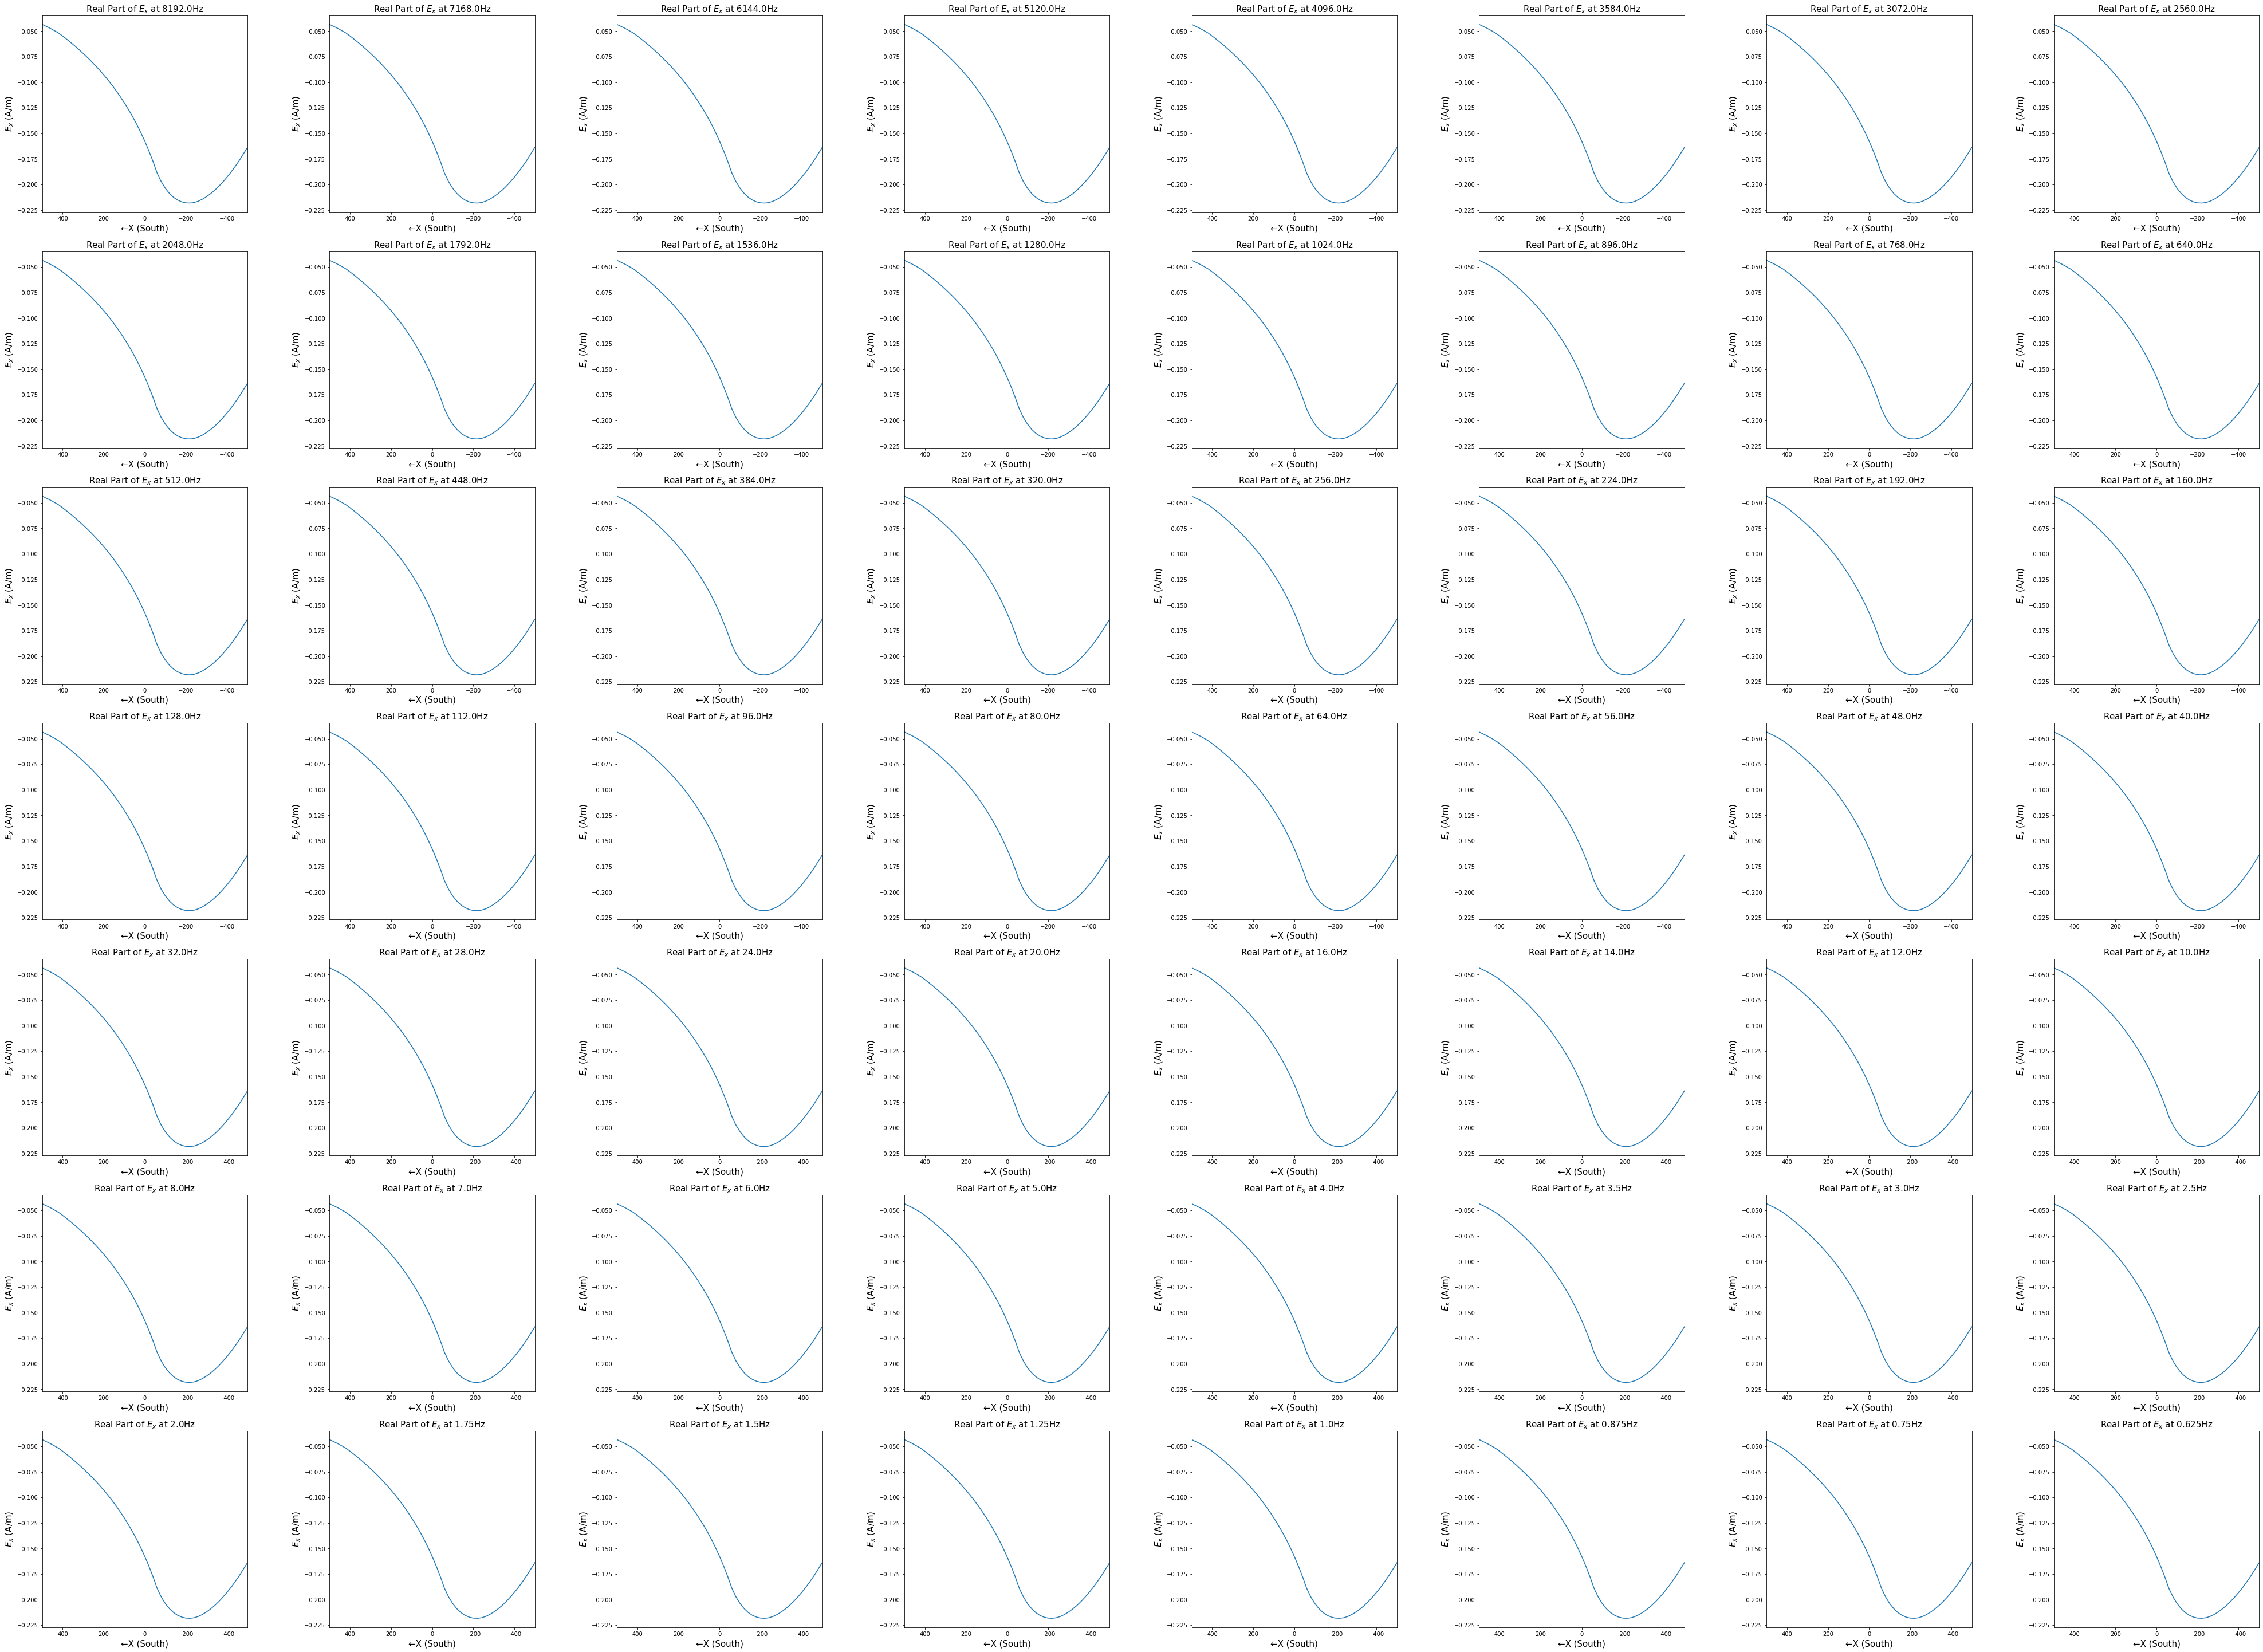

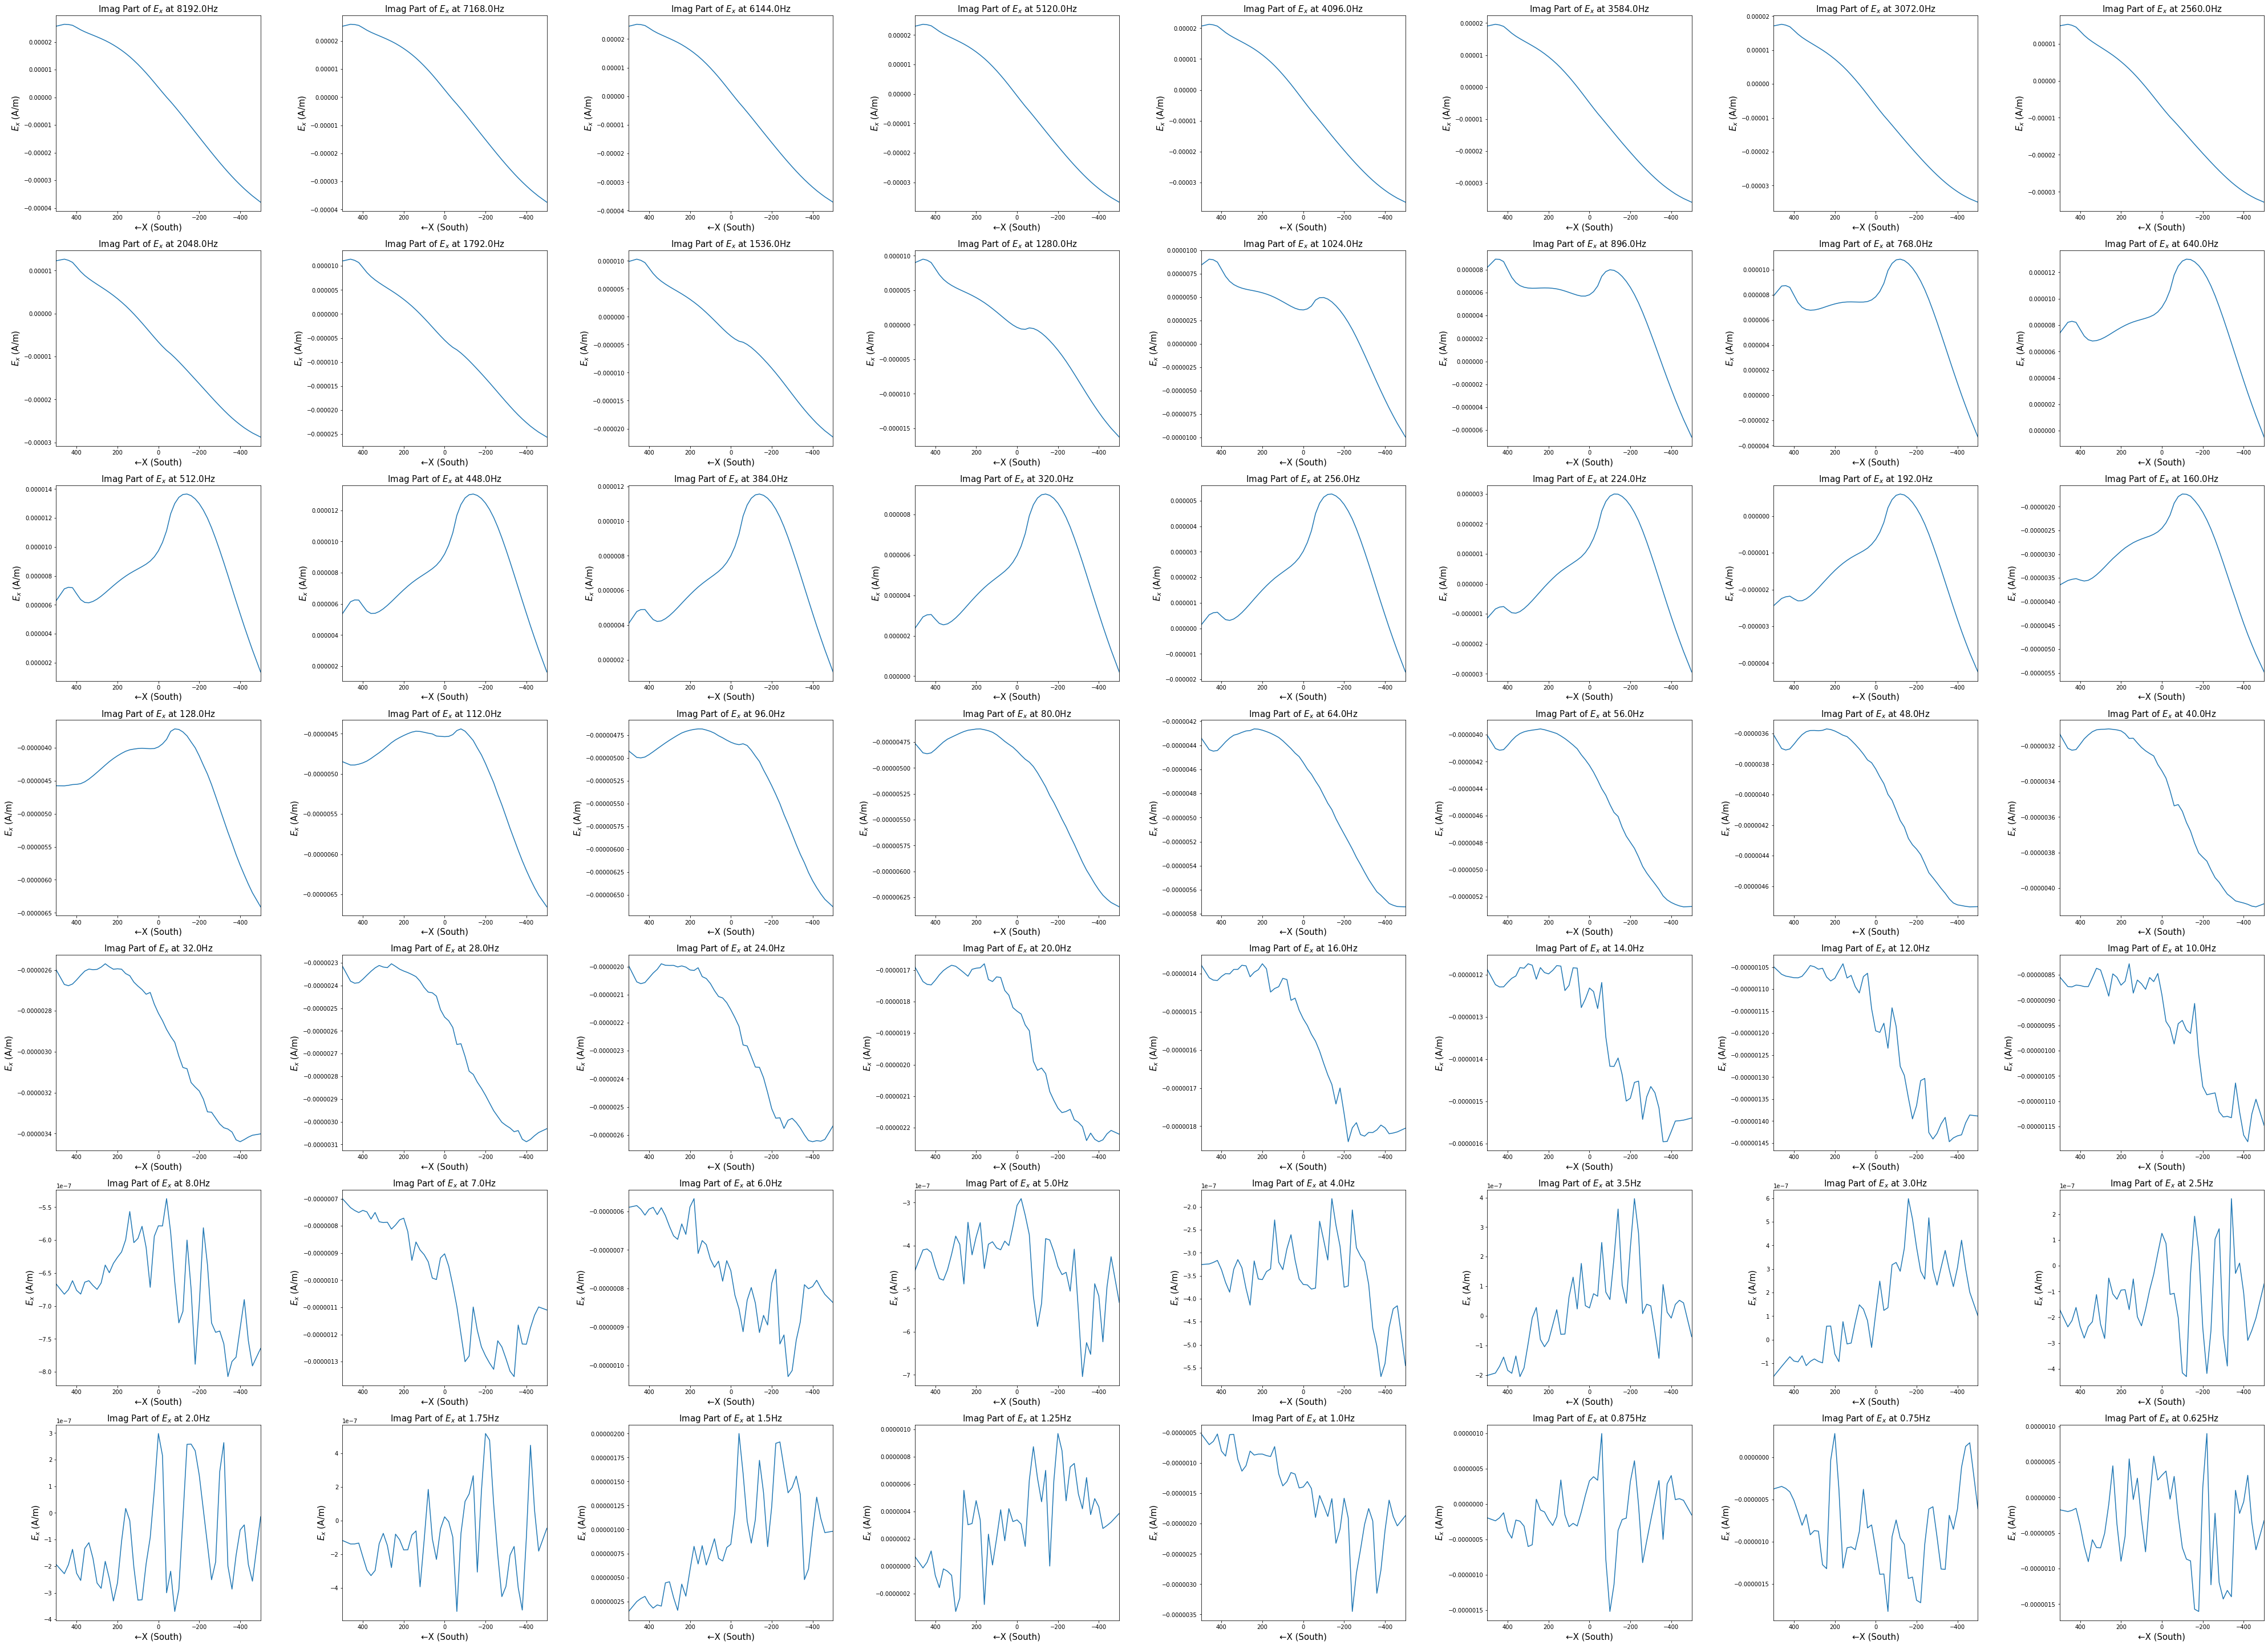

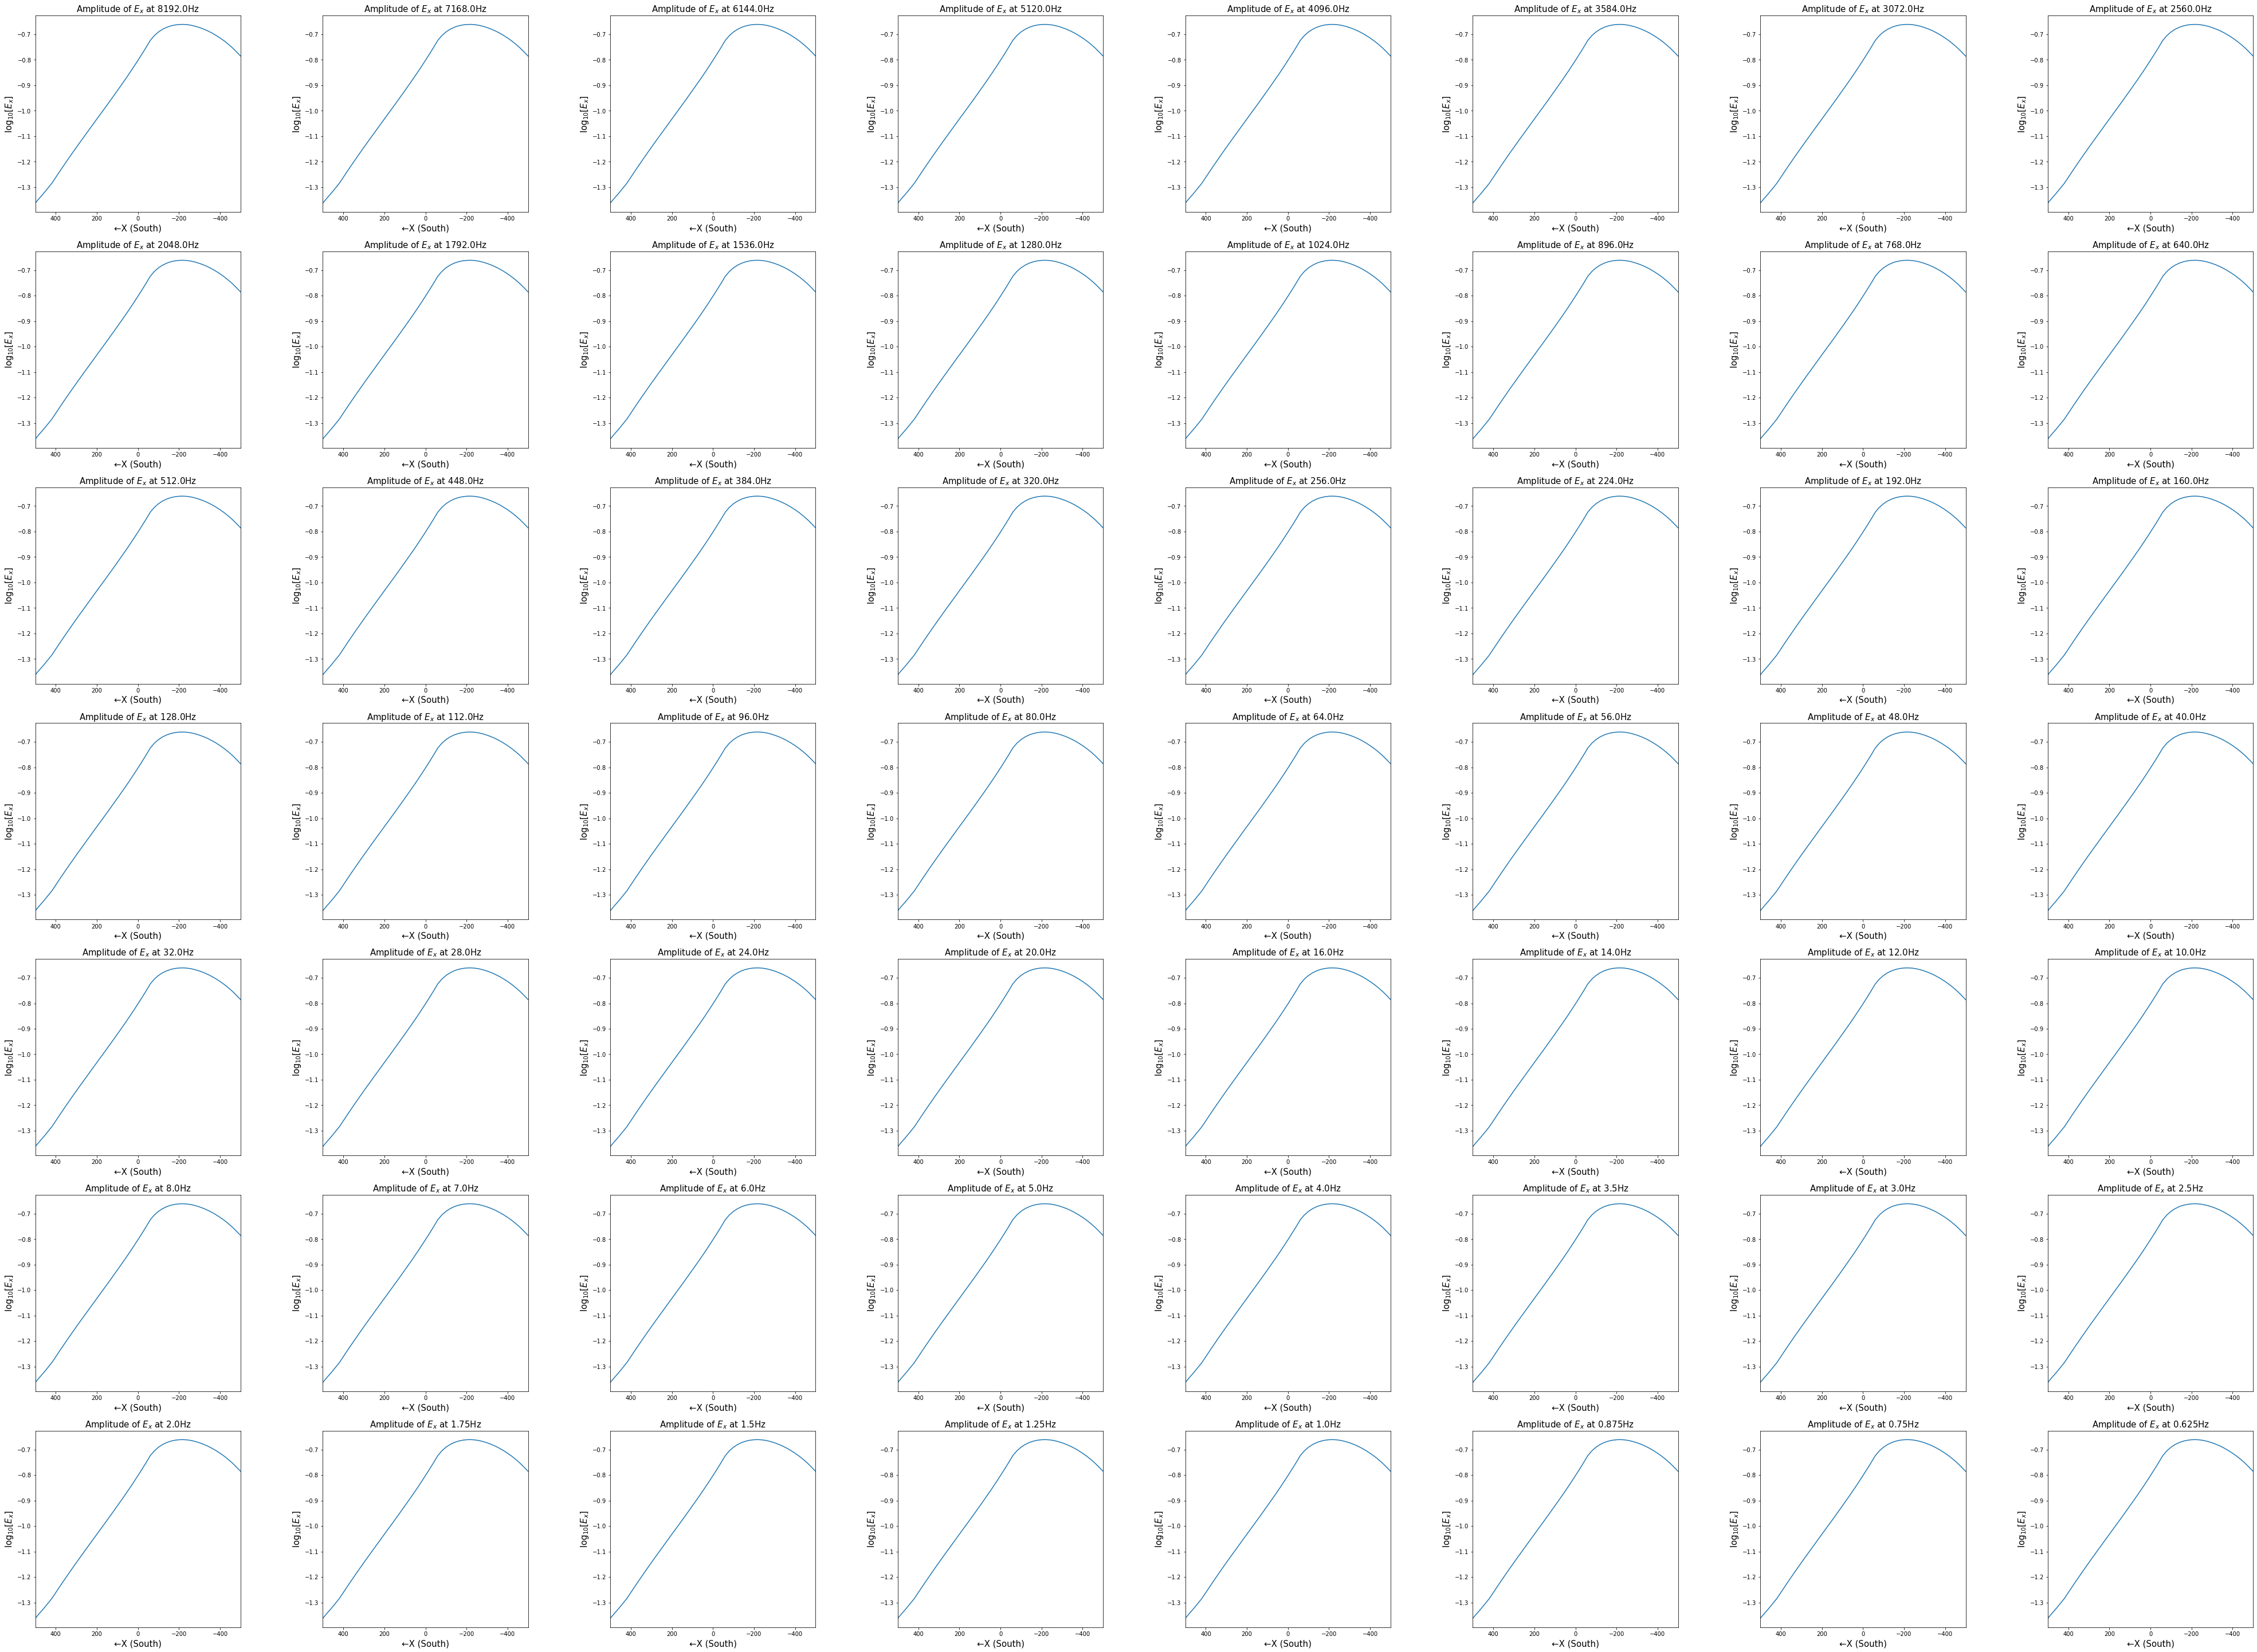

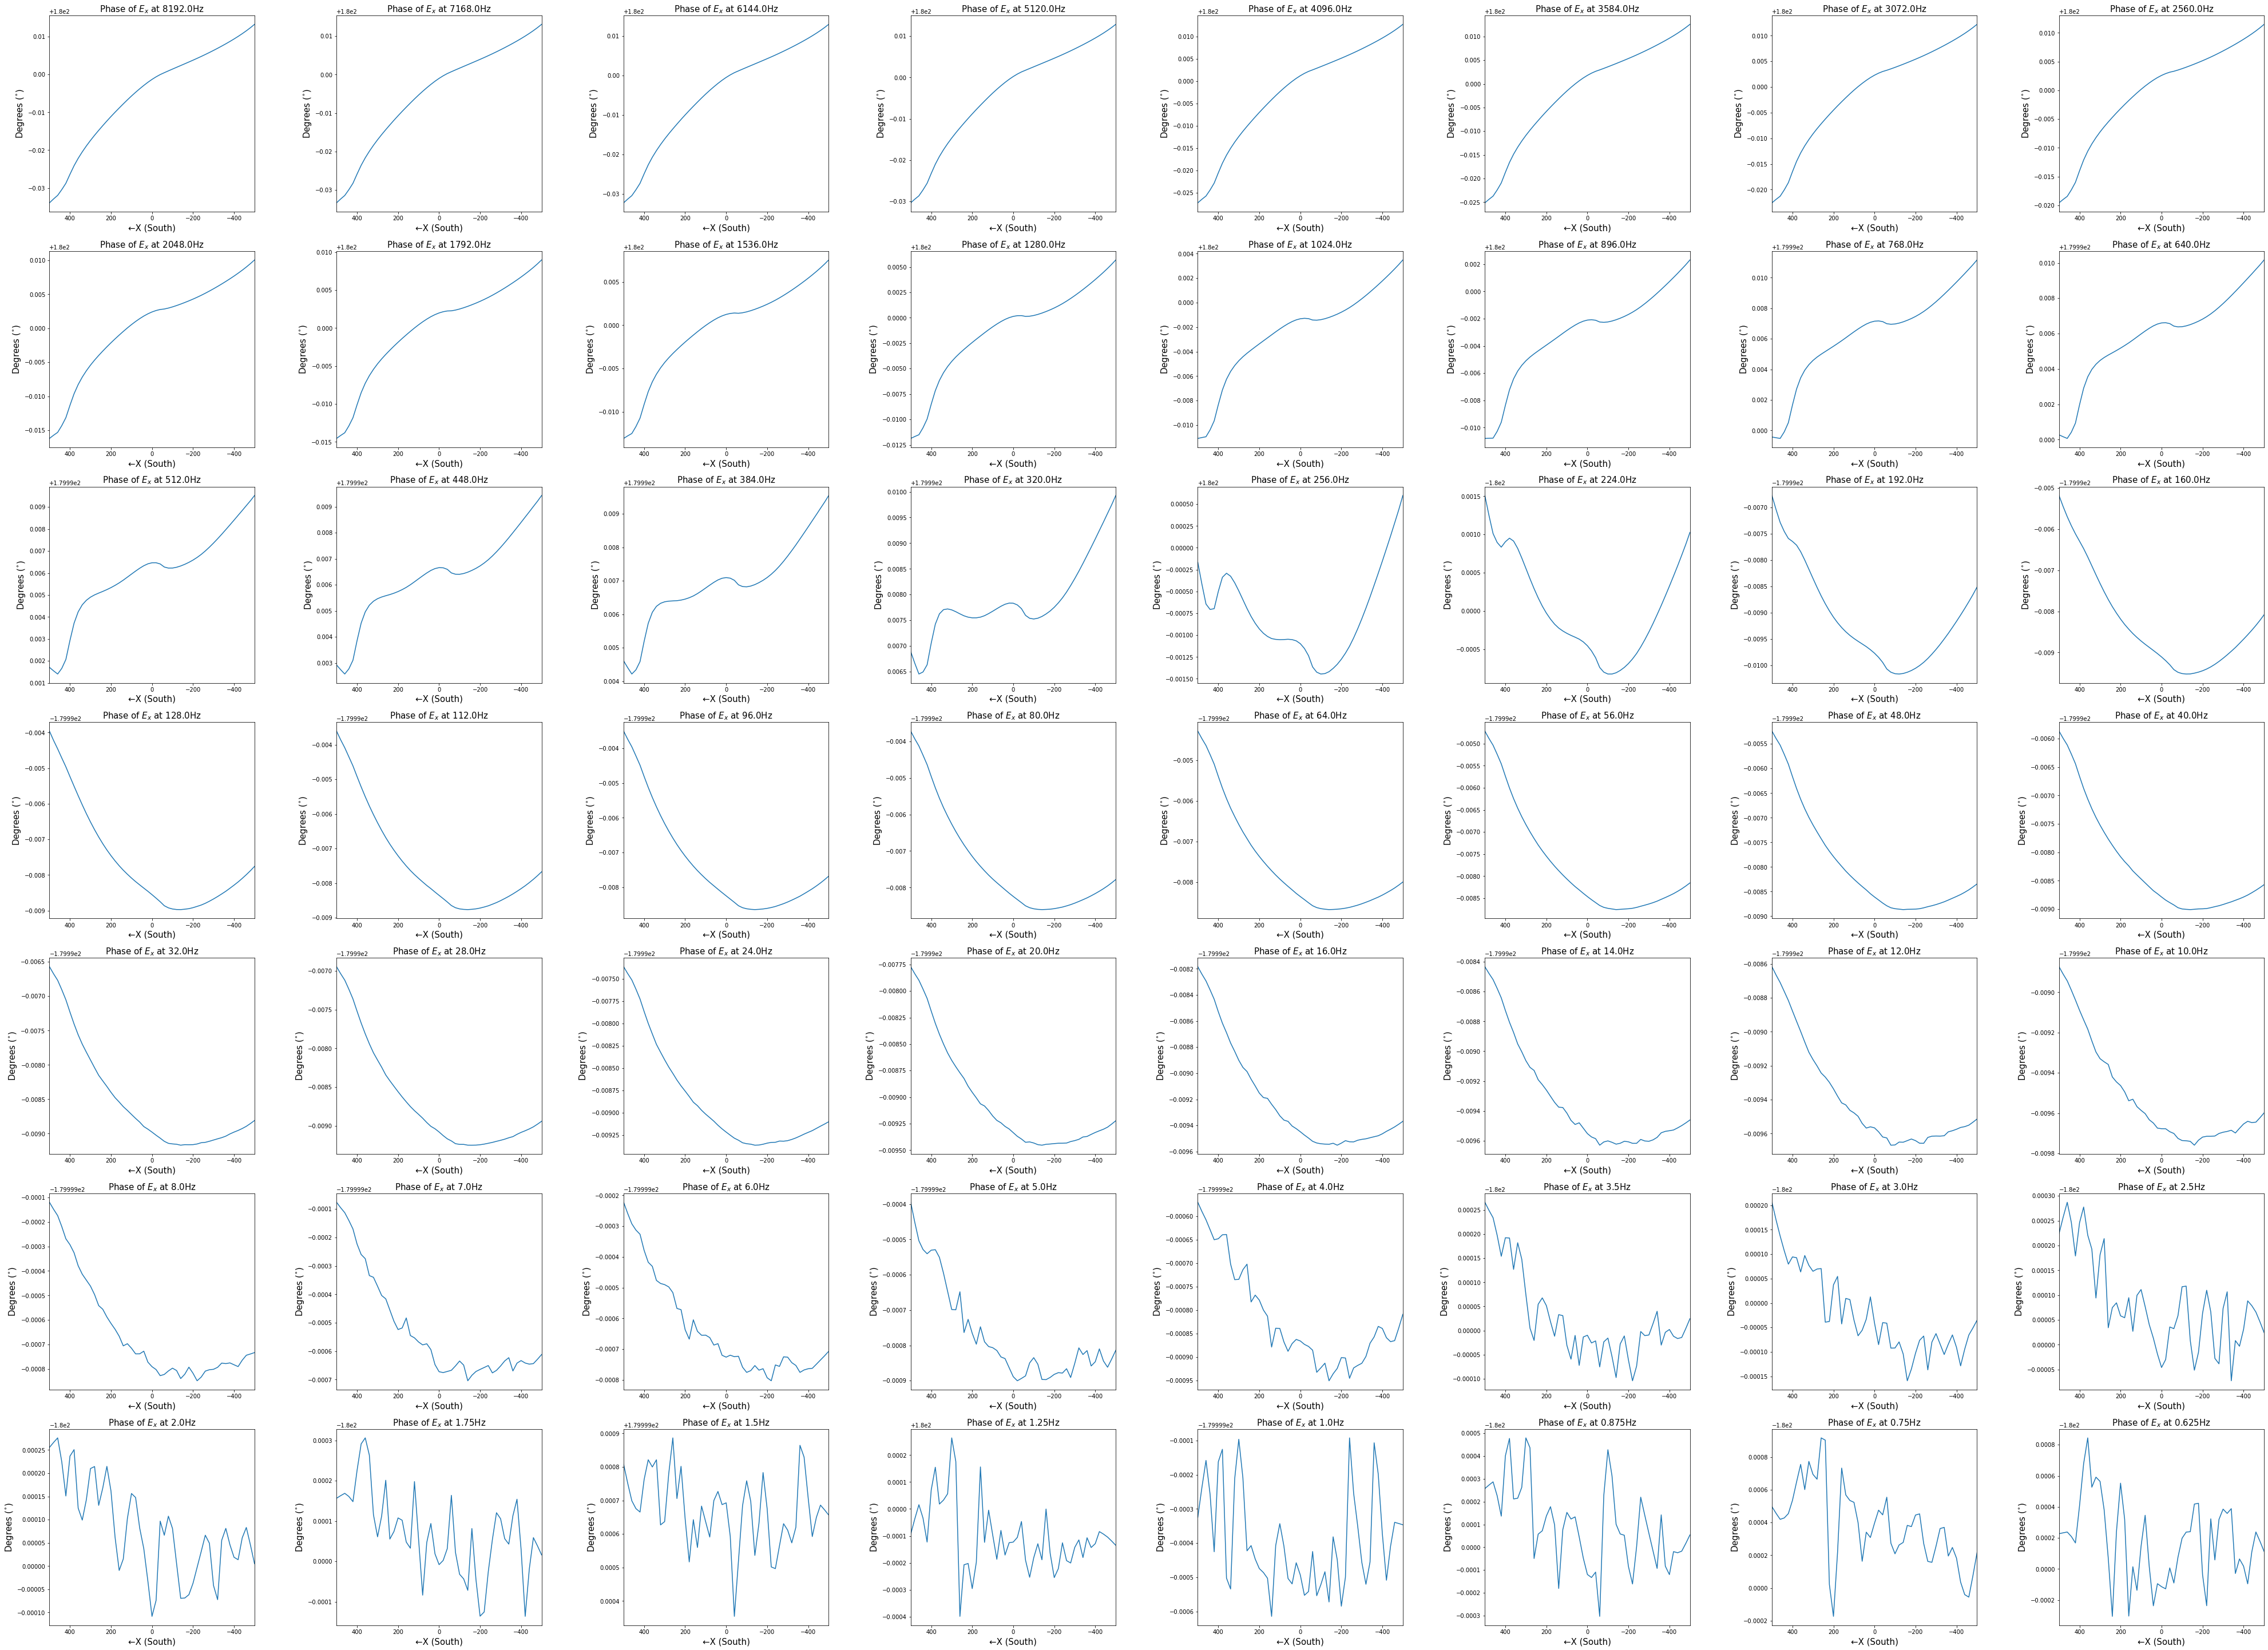

In [328]:
# Plot Data

# Determing the size of plotting grid
square = Plot_Grid(len(freq_list))

# Separate real and imaginary parts
e_data_real = np.zeros((len(freq_list), len(Rx_locs)))
e_data_imag = np.zeros((len(freq_list), len(Rx_locs)))
for freq_count in range(len(freq_list)):
    e_data_real[freq_count, :] = e_data[(2*freq_count)*len(Rx_locs):
                                        (2*freq_count)*len(Rx_locs)+len(Rx_locs)]
    e_data_imag[freq_count, :] = e_data[(2*freq_count+1)*len(Rx_locs):
                                        (2*freq_count+1)*len(Rx_locs)+len(Rx_locs)]

if Plot_Complex is True:
    # Plot the real and imag part separately over all frequencies
    Real_fig = plt.figure(5, figsize=(square*8, square*8))
    for i in range(len(freq_list)):
        # Reorganize results for plotting
        e_data_real_i = np.reshape(e_data_real[i, :], (len(Rx_loc_y), len(Rx_loc_x))).flatten()
        plt.subplots_adjust(top=0.85, bottom=0.15, left=0.11, right=0.95,
                            wspace=0.4, hspace=0.2)
        # Plot results 
        Real_plot = plt.subplot(square,square,i+1)
        Real_plot.set_title('Real Part of $E_{x}$ at '
                          + str(freq_list[i])
                          + 'Hz', fontsize=15)
        e_real_plot = plt.plot(np.flip(Rx_loc_x), e_data_real_i)
        Real_plot.set_ylabel('$E_{x}$ (A/m)', fontsize='15')
        Real_plot.set_xlabel('←X (South)', fontsize='15')
        Real_plot.set_xlim(np.max(Rx_loc_x), np.min(Rx_loc_x))
    plt.show()

    Imag_fig = plt.figure(6, figsize=(square*8, square*8))
    for j in range(len(freq_list)): 
        # Reorganize results for plotting
        e_data_imag_j = np.reshape(e_data_imag[j, :], (len(Rx_loc_y), len(Rx_loc_x))).flatten()
        plt.subplots_adjust(top=0.85, bottom=0.15, left=0.11, right=0.95,
                            wspace=0.4, hspace=0.2)
        # Plot results
        Imag_plot = plt.subplot(square,square,j+1)
        Imag_plot.set_title('Imag Part of $E_{x}$ at ' 
                           + str(freq_list[j])
                        + 'Hz', fontsize=15)
        e_imag_plot = plt.plot(np.flip(Rx_loc_x), e_data_imag_j)
        Imag_plot.set_ylabel('$E_{x}$ (A/m)', fontsize='15')
        Imag_plot.set_xlabel('←X (South)', fontsize='15')  
        Imag_plot.set_xlim(np.max(Rx_loc_x), np.min(Rx_loc_x))
    plt.show()

    if Save_Complex is True:
        # Save plot for real part
        Real_fig_name = 'CSEM Data_Real Part'
        Real_fig.savefig(Save_path + Real_fig_name + '.png',
                         transparent=True)
        
        # Save plot for imag part
        Imag_fig_name = 'CSEM Data_Imag Part'
        Imag_fig.savefig(Save_path + Imag_fig_name + '.png',
                         transparent=True)

# Calculate data amplitude and phase
e_amp = np.sqrt(e_data_real**2 + e_data_imag**2)    # Electric 
e_data_complex = e_data_real + 1j*e_data_imag
e_phase = np.degrees(np.unwrap(np.angle(e_data_complex)))

if Plot_Data is True:
    Amp_fig = plt.figure(7, figsize=(square*8, square*8))
    for i in range(len(freq_list)):
        # Reorganize results for plotting
        e_amp_i = np.reshape(e_amp[i, :], (len(Rx_loc_y), len(Rx_loc_x))).flatten()
        plt.subplots_adjust(top=0.85, bottom=0.15, left=0.11, right=0.95,
                            wspace=0.4, hspace=0.2)
        # Plot results 
        Amp_plot = plt.subplot(square,square,i+1)
        Amp_plot.set_title('Amplitude of $E_{x}$ at '
                         + str(freq_list[i])
                         + 'Hz', fontsize=15)
        e_amp_plot = plt.plot(np.flip(Rx_loc_x), np.log10(e_amp_i))
        Amp_plot.set_ylabel('$\log_{10}[E_{x}]$', fontsize='15')
        Amp_plot.set_xlabel('←X (South)', fontsize='15')
        Amp_plot.set_xlim(np.max(Rx_loc_x), np.min(Rx_loc_x))
    plt.show()
        
    Phase_fig = plt.figure(8, figsize=(square*8, square*8))
    for j in range(len(freq_list)): 
        # Reorganize results for plotting
        e_phase_j = np.reshape(e_phase[j, :], (len(Rx_loc_y), len(Rx_loc_x))).flatten()
        plt.subplots_adjust(top=0.85, bottom=0.15, left=0.11, right=0.95,
                            wspace=0.4, hspace=0.2)
        # Plot results
        Phase_plot = plt.subplot(square,square,j+1)
        Phase_plot.set_title('Phase of $E_{x}$ at ' 
                            + str(freq_list[j])
                            + 'Hz', fontsize=15)
        e_phase_plot = plt.plot(np.flip(Rx_loc_x), e_phase_j)
        Phase_plot.set_ylabel('Degrees ($^{\circ}$)', fontsize='15')
        Phase_plot.set_xlabel('←X (South)', fontsize='15')  
        Phase_plot.set_xlim(np.max(Rx_loc_x), np.min(Rx_loc_x))
    plt.show()
    
    if Save_Plot_Data is True:
        # Sace plot for amplitude data
        Amp_fig_name = 'CSEM Amplitude'
        Amp_fig.savefig(Save_path + Amp_fig_name + '.png',
                         transparent=True)
        
        # Save plot for phase data
        Phase_fig_name = 'CSEM Phase'
        Phase_fig.savefig(Save_path + Phase_fig_name + '.png',
                          transparent=True)

# Save the Ex data
if Save_Data is True:
    # Save the Ex data
    Data_file_name = 'Ex data' 
    Full_Save_Path = Save_path + Data_file_name
    np.save(Full_Save_Path, e_data)    # Save e_data as .npy file, in the same folder with figures

# Save the field parameters, invluding frequencies, Tx and Rx locations
if Save_Field_Parameter is True:
    # Save the Ex data
    Data_file_name = 'Transmitting Frequencies' 
    Full_Save_Path = Save_path + Data_file_name
    np.save(Full_Save_Path, freq_list)    # Save e_data as .npy file, in the same folder with figures

    # Save the Tx location
    Data_file_name = 'Tx location' 
    Full_Save_Path = Save_path + Data_file_name
    np.save(Full_Save_Path, Tx_locs)    # Save e_data as .npy file, in the same folder with figures

    # Save the Rx location
    Data_file_name = 'Rx location' 
    Full_Save_Path = Save_path + Data_file_name
    np.save(Full_Save_Path,Rx_locs)    # Save e_data as .npy file, in the same folder with figures

